In [431]:
import csv
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

In [442]:
# Labels for all the figures

def plot_my_data(title, data, size, labels):
    
    print("\033[1m", title, " \033[0m")

    colors=['green','skyblue', 'navy']
    library = mpatches.Patch(color='green', label='Access my personal music library')
    new = mpatches.Patch(color='skyblue', label='Discover new music')
    background = mpatches.Patch(color='navy', label='Get background music')

    plt.figure(figsize=(8, 6))
    
    for i in range(0, size):
          plt.scatter(data[i][0], data[i][1], c=colors[int(labels[i])%len(colors)])

    plt.legend(handles=[library, new, background])
    plt.show()


In [433]:
# Read the csv files

def read_csv(path):
    
    with open(path, newline='') as csvfile:

        data = []
        reader = csv.reader(csvfile, delimiter=',')
        for i, row in enumerate(reader):
            if(i>0):
                data.append(row)

        return np.array(data)

music_catalog = read_csv("public/music_catalog.csv") 
stream_logs = read_csv("public/streams_logs.csv")
survey_results = read_csv("public/survey_results.csv")
users_data = read_csv("public/users_data.csv")
users_to_predict = read_csv("public/users_to_predict.csv")


In [434]:
# Get number of tracks, number of unique tracks
def get_nb_streams(user_id): 

    tracks_ids = []

    for row in stream_logs:
        if row[2] == user_id:
            tracks_ids.append(row[0])

    nb_tracks = len(tracks_ids)
    nb_unique = len(np.unique(tracks_ids))
    
    return nb_tracks, nb_unique


In [444]:
# First dataset: two dimensions - total number of streams and number of unique streamed tracks.

# Creation of the training dataset
train_size = np.shape(survey_results)[0]
train_ids = survey_results[:,0]
train_labels = np.zeros([train_size])

for i, row in enumerate(survey_results):
    if row[1] == 'Discover new music':
        train_labels[i] = 1
    elif row[1] == 'Get background music':
        train_labels[i] = 2
    
train_data = np.zeros([train_size, 2])
for i, user_id in enumerate(train_ids):
        train_data[i][0], train_data[i][1] = get_nb_streams(user_id)
        
        
# Creation of the test dataset
X_size = np.shape(users_to_predict)[0]
X_ids = users_to_predict[:,0]
    
X = np.zeros([X_size, 2])
for i, user_id in enumerate(X_ids):
        X[i][0], X[i][1] = get_nb_streams(user_id)

 Nb de tracks uniques en fonction du nombre de streams  


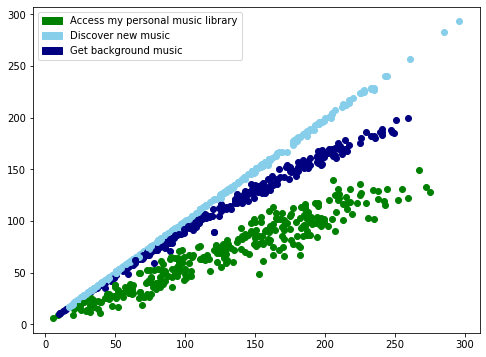

Prediction score: 0.96


In [447]:
# Training and prediction: Logistic Regression       
clf = LogisticRegression(random_state=0).fit(train_data, train_labels)
y = clf.predict(X)

plot_my_data("Nb de tracks uniques en fonction du nombre de streams", X, X_size, y)

print("Prediction score:", clf.score(train_data, train_labels))

In [ ]:
# Nous pouvons voir que la proportion de tracks uniques sur l'ensemble des streams détermine clairement nos trois 
# groupes: ainsi, les gens qui cherchent à découvrir de nouvelles musiques ne réécoutent quasiment jamais les mêmes 
# tracks, contrairement aux personnes qui écoutent de la musique à partir de leur propre librairie. Les personnes 
# qui préfèrent écouter de la musique "de fond" se situent entre les deux catégories précédemment citées. 

# Néanmoins, nous pouvons remarquer que les trois classes ne sont pas clairement identifiables lorsque le nombre 
# de streams est inférieur à 100-150. Nous avons donc besoin d'introduire d'autres variables pour "départager" ces 
# utilisateurs.

In [437]:
# Get album id and nb tracks (divide and conquer)
def get_album_by_track(tracks_list, track):
    if len(tracks_list) == 0:
        return None, 0
    else:
        m = int((len(tracks_list)-1) * 0.5)
        if int(tracks_list[m][0]) == track:
            alb_id = tracks_list[m][1]
            # Calcul du nombre de tracks par album
            alb_nb_tracks = 0
            for track in music_catalog:
                if track[1] == alb_id:
                    alb_nb_tracks += 1
                elif alb_nb_tracks > 0:
                    break
            return alb_id, alb_nb_tracks
        
        else:
            if track < int(tracks_list[m][0]):
                return get_album_by_track(tracks_list[:m], track)
            else:
                return get_album_by_track(tracks_list[m+1:], track)


# Get average of albums' streams.
def get_avg_album(user_id):
     
    albums = {}

    for row in stream_logs:
        if row[2] == user_id:
            track_id = row[0]
            alb_id, alb_nb_tracks = get_album_by_track(music_catalog, int(track_id))

            if alb_id in albums.keys() and track_id not in albums[alb_id]['streamed_tracks']:
                albums[alb_id]['streamed_tracks'].append(track_id)
            else:
                albums[alb_id] = {'nb_tracks': alb_nb_tracks, 
                                  'streamed_tracks': [track_id]}
    proportions = []
    for k in albums.keys():
        albums[k]['nb_streamed_tracks'] = len(albums[k]['streamed_tracks'])
        proportions.append(albums[k]['nb_streamed_tracks'] / albums[k]['nb_tracks'])
        
    return np.average(proportions)

In [448]:
# Second dataset: two dimensions - proportion of unique streamed tracks and proportion of albums' streams.

# Creation of the training dataset
for i, user_id in enumerate(train_ids):
        nb_tracks, nb_unique = get_nb_streams(user_id)
        train_data[i][0] = nb_unique / nb_tracks
        train_data[i][1] = get_avg_album(user_id)
        
        
# Creation of the test dataset
for i, user_id in enumerate(X_ids):
        nb_tracks, nb_unique = get_nb_streams(user_id)
        X[i][0] = nb_unique / nb_tracks
        X[i][1] = get_avg_album(user_id)  

 Écoutes par albums en fonction de la proportion de tracks uniques - 1 ppv  


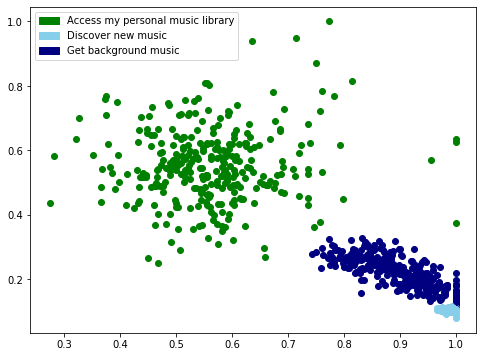

Prediction score: 1.0


In [454]:
# Training and prediction: K-closest neigbours       
neigh = KNeighborsClassifier(n_neighbors=1).fit(train_data, train_labels)
y = neigh.predict(X)

plot_my_data("Écoutes par albums en fonction de la proportion de tracks uniques - 1 ppv", X, X_size, y)

print("Prediction score:", neigh.score(train_data, train_labels))

In [440]:
# Correlation entre habitudes d'écoute et âge

age = np.zeros([train_size])

for i, user_id in enumerate(train_ids):
    for row in users_data:
        if row[0] == user_id:
            if row[1] == '25-34':
                age[i] = 1
            elif row[1] == '35-44':
                age[i] = 2
            elif row[1] == '45-54':
                age[i] = 3
            elif row[1] == '55-65':
                age[i] = 4
                
print("Correlation entre l'âge et la réponse lors du sondage:", abs(np.corrcoef(train_labels, age)[0][1]))

# Il n'y a pas de correlation entre l'âge d'un utilisateur et sa réponse lors du sondage.
# Nous ne nous intéresserons donc pas à cette variable.

Correlation entre l'âge et la réponse lors du sondage: 0.23726271735508622


In [441]:
# Get track duration
def get_track_duration(tracks_list, track):
    if len(tracks_list) == 0:
        return None, 0
    else:
        m = int((len(tracks_list)-1) * 0.5)
        if int(tracks_list[m][0]) == track:
            duration = int(float(tracks_list[m][2]))
            return duration
        
        else:
            if track < int(tracks_list[m][0]):
                return get_track_duration(tracks_list[:m], track)
            else:
                return get_track_duration(tracks_list[m+1:], track)
            
# Get proportion of skipped tracks.
def get_skipped_tracks_proportion(user_id):
     
    streams = []

    for row in stream_logs:
        if row[2] == user_id:
            track_id = row[0]
            timestamp = row[1]
            duration = get_track_duration(music_catalog, int(track_id))

            streams.append({'track_id': track_id, 
                         'duration': duration,
                         'timestamp': timestamp})
    skipped = 0
    
    for i, stream in enumerate(streams):
        if i+1 < len(streams):
            interval = int(streams[i+1]['timestamp']) - int(streams[i]['timestamp'])
            if interval < streams[i]['duration']:
                skipped += 1
                    
    return skipped / len(streams)

In [455]:
# Correlation entre habitudes d'écoute et âge

skipped_prop = np.zeros([train_size])
for i, user_id in enumerate(train_ids):
    skipped_prop[i] = get_skipped_tracks_proportion(user_id)

print("Correlation entre la proportion de tracks passés et la réponse lors du sondage:", 
      abs(np.corrcoef(skipped_prop, train_labels)[0][1]))

# Il n'y a pas de correlation entre la proportion de tracks passés et la réponse lors du sondage.
# Nous ne nous intéresserons donc pas à cette variable.

Correlation entre la proportion de tracks passés et la réponse lors du sondage: 0.14104097075668812


In [462]:
# Export des résultats de la prédiction dans solution.csv

with open('solution.csv', 'w', newline='') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    spamwriter.writerow(['user_id', 'predicted_survey_answer'])
    
    for i,label in enumerate(y):
        if label == 0:
            spamwriter.writerow([X_ids[i], 'Access my personal music library'])
        elif label == 1:
            spamwriter.writerow([X_ids[i], 'Discover new music'])
        else:
            spamwriter.writerow([X_ids[i], 'Get background music'])